# CSC 446 Project: Load-balancing with Random Choices
CSC446 - Project Load-balancing with Random Choices

   Team members: Pengfei Li (V00831098)
                 Zexi Luo (V00929142)
                 Yulei Jiang (V00019319)

   Description: This project explores the effects of a first-in, first-out (FIFO) queue on a service-oriented problem
              where customers arrive randomly for service. The system is simulated using Python.
              The objective of this project is to compare the performance of two baseline methods.
               The first method is Purely random, in which the load balancer randomly selects a server from a pool of servers and
               dispatches the incoming customer to the selected server. The second method is Round-robin, in which the load balancer
               uses a round-robin method to dispatch incoming customers. Finally, in the last part of this report, we
               analyze the model as a FIFO queue using the Purely random and Round-robin methods to compare their performance in terms
               of maximum workload, average workload, and average system time, as determined by our simulation results.



# Code




 Strategy: RR - Max queue length: 113 - Average queue length: 65.63
 Average system time: 49.790143586957846
 Strategy: PureRand - Max queue length: 87 - Average queue length: 52.60
 Average system time: 42.158547624978866
 Strategy: RandMin - Max queue length: 104 - Average queue length: 57.47
 Average system time: 46.040771405293526



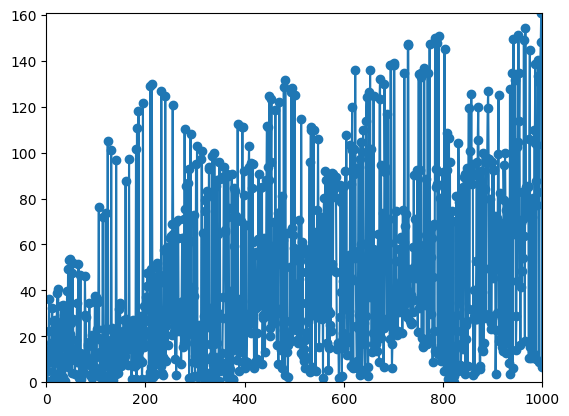

In [1]:


import simpy
import random
from prettytable import PrettyTable
import matplotlib.pyplot as plt

class LoadBalancer:
    def __init__(self, env, num_servers, strategy, num_sample_servers, service_rate):
        self.env = env
        self.servers = [simpy.Resource(env, capacity=1)
                        for _ in range(num_servers)]
        self.strategy = strategy
        self.num_sample_servers = num_sample_servers
        self.current_server = 0
        self.service_rate = service_rate

        self.num_intervals = 0
        self.departure_times = []
        self.processed_customers = []
        self.arrival_times = []
        self.service_time = []
        self.queue_lengths = []
        self.total_queue_length = 0

    def customer_arrives(self, customer):
        self.total_queue_length += 1
        self.queue_lengths.append(self.total_queue_length)

    def customer_departs(self, customer):
        self.total_queue_length -= 1

    def update_queue_length(self):
        total_queue_length = sum(server.count for server in self.servers)
        self.queue_lengths.append(total_queue_length)

    def choose_server(self):
        if self.strategy == "RandMin":
            selected_servers = random.sample(
                self.servers, self.num_sample_servers)
            return min(selected_servers, key=lambda x: x.count)
        if self.strategy == "PureRand":
            return random.choice(self.servers)
        elif self.strategy == "RR":
            server = self.servers[self.current_server]
            self.current_server = (self.current_server + 1) % len(self.servers)
            return server

    def process_customer(self, customer):
        server = self.choose_server()
        with server.request() as req:
            self.customer_arrives(customer)
            yield req
            self.customer_departs(customer)

            service_time = random.expovariate(self.service_rate)
            customer.service_time = service_time
            yield self.env.timeout(service_time)
            customer.set_departure_time(self.env.now)
            self.departure_times.append(customer.departure_time)
            self.processed_customers.append(customer)

    def avg_system_time(self):
        system_times = [customer.departure_time -
                        customer.arrival_time for customer in self.processed_customers]
        avg_system_time = sum(system_times) / \
            len(system_times) if system_times else 0
        return avg_system_time


class Customer:
    def __init__(self, name, arrival_time):
        self.name = name
        self.arrival_time = arrival_time
        self.departure_time = None
        self.service_time = None

    def set_departure_time(self, time):
        self.departure_time = time

    def system_time(self):
        return self.departure_time - self.arrival_time if self.departure_time is not None else None


def customer_generator(env, load_balancer, num_customers, arrival_rate):
    for i in range(num_customers):
        yield env.timeout(random.expovariate(arrival_rate))
        customer = Customer(i+1, env.now)
        env.process(load_balancer.process_customer(customer))


def storage(strategy, customer, interArrival, arrivals, serviceT, serviceBegin, queueTime, departures, inSys):
    return{'strategy_name': strategy, 'customer_Num': customer, 'inter_arrival_time': interArrival,
           'arrival_time': arrivals, 'service_time': serviceT, 'time_service_begin': serviceBegin,
           'time_in_queue': queueTime, 'departures': departures, 'time_in_system': inSys}


def main():

    # 10 20 30 40 50
    random.seed(2)

    num_servers = 10
    # 100 1000
    num_customers = 1000

    # 100 customers per hour (60 min) 100/60 = 1.6
    # 1200/60 = 3.33
    arrival_rate = 1.6
    # 10  customers per hour (60 min) 10/60 = 0.16
    # 0.112 0.16 0.23
    service_rate = 0.16

    strategies = ["RR", "PureRand", "RandMin"]
    # random servers to select from total servers for RandMin method
    # 2 7
    num_sample_servers = 2

    # saved all data
    save = []

    for strategy in strategies:

        customerNum = []
        interArrival = []
        arrivals = []
        serviceT = []
        serviceBegin = []
        queueTime = []
        departures = []
        inSys = []

        env = simpy.Environment()
        load_balancer = LoadBalancer(
            env, num_servers, strategy, num_sample_servers, service_rate)
        env.process(customer_generator(
            env, load_balancer, num_customers, arrival_rate))
        env.run()

        max_queue_length = max(load_balancer.queue_lengths)
        avg_queue_length = sum(load_balancer.queue_lengths) / \
            len(load_balancer.queue_lengths)
        print(
            f" Strategy: {strategy} - Max queue length: {max_queue_length} - Average queue length: {avg_queue_length:.2f}")
        print(f" Average system time: {load_balancer.avg_system_time()}")

        interArrival.append(load_balancer.processed_customers[0].arrival_time)

        for customer in load_balancer.processed_customers:
            customerNum.append(customer.name)
            # if index > 0 and index < num_customers:
            #     interArrival.append(customer.arrival_time - interArrival[index - 1])
            arrivals.append(customer.arrival_time)
            serviceT.append(customer.service_time)
            serviceBegin.append(customer.departure_time - customer.service_time)
            queueTime.append(customer.departure_time - customer.arrival_time - customer.service_time)
            departures.append(customer.departure_time)
            inSys.append(customer.system_time())

        # Num | arrival | serviceT | serviceB | Qtime | Dep | inSys
        T1 = []
        for i in range(num_customers):
            T1.append([customerNum[i], arrivals[i], serviceT[i], serviceBegin[i], queueTime[i], departures[i], inSys[i]])

        T1.sort(key = lambda x:x[0])

        # Num | arrival | serviceT | serviceB | Qtime | Dep | inSys
        T1_trans = [list(), list(), list(), list(), list(), list(), list()]
        for x in T1:
            T1_trans[0].append(x[0])
            T1_trans[1].append(x[1])
            T1_trans[2].append(x[2])
            T1_trans[3].append(x[3])
            T1_trans[4].append(x[4])
            T1_trans[5].append(x[5])
            T1_trans[6].append(x[6])

        for i in range(1, num_customers):
            interArrival.append(T1_trans[1][i] - T1_trans[1][i - 1])

        save.append(storage(strategy, T1_trans[0], interArrival, T1_trans[1], T1_trans[2], T1_trans[3], T1_trans[4], T1_trans[5], T1_trans[6]))

    # for s in save:
    #     print()
    #     print('The strategy is: ', s.get('strategy_name'))
    #     print()
    #     x = PrettyTable()
    #     column_names = ['Customer', 'IAT', 'AT',
    #                     'ST', 'TSB', 'TCWQ', 'TSE', 'TCSS']
    #     data = [s.get('customer_Num'), s.get('inter_arrival_time'), s.get('arrival_time'), s.get('service_time'), s.get('time_service_begin'),
    #             s.get('time_in_queue'), s.get('departures'), s.get('time_in_system')]
    #     length = len(column_names)
    #     for i in range(length):
    #         x.add_column(column_names[i], data[i])
    #     print(x)
    #     # for x in range(len(s.get('customer_Num'))):
    #     #     print('CusNum: ', s.get('customer_Num')[x], 'interArr: ', s.get('inter_arrival_time')[x], 'ArrT: ', s.get('arrival_time')[x], 'serviceT: ', s.get('service_time')[
    #     #           x], 'serviceBegin: ', s.get('time_service_begin')[x], 'Time_in_queue: ', s.get('time_in_queue')[x], 'departureT: ', s.get('departures')[x], 'Time_in_sys: ', s.get('time_in_system')[x])

    # plt.plot(save[2].get('customer_Num'), save[2].get('inter_arrival_time'), marker = 'o')
    # # x-min x-max y-min y-max
    # plt.axis([0, num_customers, 0, max(save[2].get('inter_arrival_time'))])
    # plt.figure(figsize=(1920,1080))
    # print()
    # plt.show() 
    # print()

    plt.plot(save[2].get('customer_Num'), save[2].get('time_in_system'), marker = 'o')
    # x-min x-max y-min y-max
    plt.axis([0, num_customers, 0, max(save[2].get('time_in_system'))])
    print()
    plt.show() 
    print()


# ---------------------------------------------------------------------------------------------------------------------------------------
# How to get data
# save[] have 3 items in the list ["RR", "PureRand", "RandMin"]
# Each item is a dictionary with strategy name, customer index, interArrival, arrivals, serviceT, serviceBegin, queueTime, departures, inSys
# strategy name is a string, the rest are all lists contains the data
# Feel free to use these data by calling save[1 2 3].get('keyname') to get the list
# key name can be found in def storage function
# ---------------------------------------------------------------------------------------------------------------------------------------


if __name__ == "__main__":
    main()


